### Load Data and View Image ###

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
142


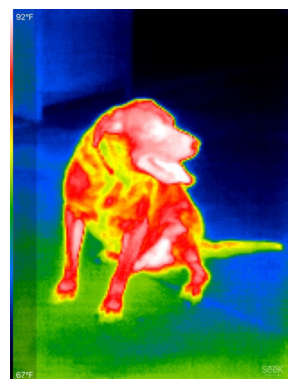

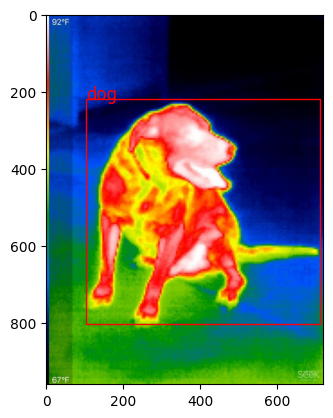

In [4]:
import os
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data_dir = '/home/hgq/Projects/DLF/dog'
splits = ['train', 'valid', 'test']

for split in splits:
    image_dir = os.path.join(data_dir, split)
    ann_file = os.path.join(image_dir, '_annotations.coco.json')

    coco = COCO(ann_file)

    img_ids = coco.getImgIds()
    print(len(img_ids))

    img_info = coco.loadImgs(img_ids[0])[0] 
    image_path = os.path.join(image_dir, img_info['file_name'])
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(ann_ids)

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for ann in annotations:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1], category_name, color='red', fontsize=12)

    plt.show()

    break


In [5]:
import torch
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import copy

train_ann = "/home/hgq/Projects/DLF/dog/train/_annotations.coco.json"
valid_ann = "/home/hgq/Projects/DLF/dog/valid/_annotations.coco.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_dir = '/home/hgq/Projects/DLF/dog/train'
dataset = CustomDataset(train_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
total_images_count = 0

for images in loader:
    batch_images_count = images.size(0)
    images = images.view(batch_images_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_images_count

mean /= total_images_count
std /= total_images_count

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.2885, 0.3756, 0.3216])
Standard Deviation: tensor([0.3790, 0.2832, 0.2951])


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training with lr=0.1, optimizer=Adam, weight_decay=0, use_residual_links=True
tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1,
        2, 2, 2, 2, 2, 2, 1, 1], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([1, 1, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
Epoch [1/50], Train Loss: 5.1760, Valid Loss: 9455114.2500, Train Acc: 0.3893, Valid Acc: 0.5000
tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1,
        2, 2, 2, 2, 2, 2, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 2, 2], device='cuda:0')
tensor([1, 1, 1, 1], devi

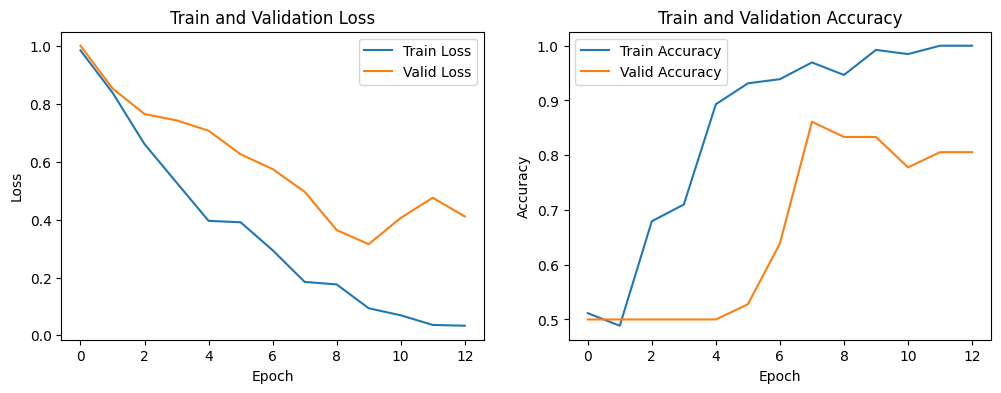

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2885, 0.3756, 0.3216], std=[0.3790, 0.2832, 0.2951])
])

class CustomCOCODataset(Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.image_dir = image_dir
        self.transform = transform
        self.img_ids = [img_id for img_id in self.img_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        label = annotations[0]['category_id']
        return image, label

# Define Resnet-18
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_residual_links=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.use_residual_links = use_residual_links

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.use_residual_links:
            out += identity
        
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3, use_residual_links=True):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks with parameter use_residual_links
        self.layer1 = self._make_layer(64, 2, stride=1, use_residual_links=use_residual_links)
        self.layer2 = self._make_layer(128, 2, stride=2, use_residual_links=use_residual_links)
        self.layer3 = self._make_layer(256, 2, stride=2, use_residual_links=use_residual_links)
        self.layer4 = self._make_layer(512, 2, stride=2, use_residual_links=use_residual_links)

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride, use_residual_links):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample, use_residual_links)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, use_residual_links=use_residual_links))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

train_dataset = CustomCOCODataset(os.path.join(data_dir, 'train'), os.path.join(data_dir, 'train/_annotations.coco.json'), transform=transform)
valid_dataset = CustomCOCODataset(os.path.join(data_dir, 'valid'), os.path.join(data_dir, 'valid/_annotations.coco.json'), transform=transform)

fixed_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=fixed_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=fixed_batch_size, shuffle=False)

# Update the grid search parameter list
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "optimizer": ["Adam", "SGD"],
    "weight_decay": [0, 0.01, 0.001],
    "use_residual_links": [True, False]
}

def train_and_evaluate_model(learning_rate, optimizer_name, weight_decay, use_residual_links):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet18(num_classes=3, use_residual_links=use_residual_links).to(device)
    early_stop_patience = 3
    best_valid_loss = float('inf')
    early_stop_counter = 0
    model = ResNet18(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)


    best_model_weights = copy.deepcopy(model.state_dict())


    num_epochs = 50
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        valid_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                print(labels)
                print(predicted)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Valid Acc: {valid_accuracy:.4f}")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered")
                break
    
    return best_valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies


# Grid Search with saving curves
best_params = None
best_score = float('inf')
best_model_path = 'best_model.pth'
best_params_path = 'best_params.pth'

for lr in param_grid['learning_rate']:
    for optimizer_name in param_grid['optimizer']:
        for weight_decay in param_grid['weight_decay']:
            for use_residual_links in param_grid['use_residual_links']:
                print(f"Training with lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, "
                      f"use_residual_links={use_residual_links}")
                valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate_model(
                    lr, optimizer_name, weight_decay, use_residual_links
                )
                if valid_loss < best_score:
                    best_score = valid_loss
                    best_params = {
                        'learning_rate': lr, 'optimizer': optimizer_name, 
                        'weight_decay': weight_decay, 'use_residual_links': use_residual_links
                    }
                    torch.save(best_model_weights, best_model_path)

print("Best parameters:", best_params)



# Plot loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()


### Test Results ###

In [9]:
import torch
from sklearn.metrics import f1_score


test_dataset = CustomCOCODataset(
    os.path.join(data_dir, 'test'), 
    os.path.join(data_dir, 'test/_annotations.coco.json'), 
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=3).to(device)
model.load_state_dict(torch.load('best_model.pth'))  

def evaluate_on_test_set(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test F1 Score: {f1:.4f}")

evaluate_on_test_set(model)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test F1 Score: 0.8889
